# Insert MERIT Hydro elevation in SUMMA set up
Inserts elevation of each HRU into the attributes `.nc` file. The intersection code stores this value in field `elev_mean`. 

If the field `settings_summa_connect_HRUs` is set to `yes` in the control file, this script also finds the downslope HRU (attribute `downHRUindex`) for the HRUs within each GRU. The most downstream HRU (i.e. the GRU outlet) is set to `0` to follow SUMMA conventions. If `settings_summa_connect_HRUs` is set to `no`, all HRUs are modelled as indepdendent columns and outflow from all HRUs inside each GRU is combined into basin-average outflow. No further action is needed, as `downHRUindex` for each HRU has already been set to `0`.

In [1]:
# modules
import os
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find shapefile location and name

In [6]:
# Path to and name of shapefile with intersection between catchment and soil classes
intersect_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
intersect_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

In [7]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [8]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')
intersect_gruId_var = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')

#### Find where the attributes file is

In [9]:
# Attribute path & name
attribute_path = read_from_control(controlFolder/controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFolder/controlFile,'settings_summa_attributes')

In [10]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA') # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the shapefile

In [11]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

#### Define `downHRUindex` values if requested

In [12]:
# Create a field with downHRUindex = 0, that we wil potentially overwrite
shp['downHRUindex'] = 0

# Find if this is requested by the user
do_downHRUindex = read_from_control(controlFolder/controlFile,'settings_summa_connect_HRUs')

In [13]:
# Find the downHRUindex value if requested
if do_downHRUindex.lower() == 'yes':
    
    # Find the unique GRU IDs
    gru_ids = shp[intersect_gruId_var].unique()
    
    # Create a temporary field we'll fill
    shp['downHRUindex'] = 0
    
    # Make hruId the index
    shp.set_index(intersect_hruId_var, inplace=True)
    
    # Loop over the GRUs
    for gru_id in gru_ids:
    
        # Select only the GRU we're currently working on
        gru_mask = (shp[intersect_gruId_var] == gru_id)
    
        # Find the soring order of HRUs in this GRU based on their elevations
        tmp_sort = shp[gru_mask]['elev_mean'].argsort()
    
        # Loop over the HRUs in this GRU and set their downHRUindex in the shapefile
        HRUs_seen = 0
        last_HRU = 0
        for HRU,order in tmp_sort.iteritems():
            if order == 0: 
                # most downstream HRU
                print('Filling downHRUindex of HRU {} with HRU {}'.format(last_HRU,HRU)) 
                print('Filling downHRUindex of HRU {} with HRU {}'.format(HRU,0)) 
                if last_HRU != 0: # If there are more HRUs in this GRU ...
                    shp.at[last_HRU, 'downHRUindex'] = int(HRU) # fill the second-to last and also ...
                shp.at[HRU,      'downHRUindex'] = 0   # fill the last (possibly only) HRU
            elif HRUs_seen > 0:
                # not the first iteration
                print('Filling downHRUindex of HRU {} with HRU {}'.format(last_HRU,HRU))        
                shp.at[last_HRU, 'downHRUindex'] = int(HRU)
            HRUs_seen += 1
            last_HRU = HRU
            
    # Reset the index
    shp.reset_index(inplace=True)

Filling downHRUindex of HRU 48 with HRU 97
Filling downHRUindex of HRU 97 with HRU 118
Filling downHRUindex of HRU 118 with HRU 0
Filling downHRUindex of HRU 1 with HRU 49
Filling downHRUindex of HRU 49 with HRU 100
Filling downHRUindex of HRU 100 with HRU 0
Filling downHRUindex of HRU 2 with HRU 50
Filling downHRUindex of HRU 50 with HRU 101
Filling downHRUindex of HRU 101 with HRU 0
Filling downHRUindex of HRU 3 with HRU 51
Filling downHRUindex of HRU 51 with HRU 102
Filling downHRUindex of HRU 102 with HRU 0
Filling downHRUindex of HRU 4 with HRU 52
Filling downHRUindex of HRU 52 with HRU 103
Filling downHRUindex of HRU 103 with HRU 0
Filling downHRUindex of HRU 5 with HRU 53
Filling downHRUindex of HRU 53 with HRU 104
Filling downHRUindex of HRU 104 with HRU 0
Filling downHRUindex of HRU 6 with HRU 54
Filling downHRUindex of HRU 54 with HRU 105
Filling downHRUindex of HRU 105 with HRU 0
Filling downHRUindex of HRU 7 with HRU 55
Filling downHRUindex of HRU 55 with HRU 106
Filling do

#### Open the attributes file and fill the placeholder values in the attributes file

In [15]:
# Open the netcdf file for reading+writing
with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
    
    # Loop over the HRUs in the attributes
    for idx in range(0,len(att['hruId'])):
        
        # Find the HRU ID (attributes file) at this index
        attribute_hru = att['hruId'][idx]
    
        # Find the row in the shapefile that contains info for this HRU
        shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
        
        # Find the elevation & downHRUindex
        tmp_elev = shp['elev_mean'][shp_mask].values[0]
        tmp_down = shp['downHRUindex'][shp_mask].values[0]
        
        # Replace the value
        print('Replacing elevation {} [m] with {} [m] at HRU {}'.format(att['elevation'][idx],tmp_elev,attribute_hru))
        att['elevation'][idx] = tmp_elev
        
        if do_downHRUindex.lower() == 'yes':
            print('Replacing downHRUindex {} with {} at HRU {}'.format(att['downHRUindex'][idx],tmp_down,attribute_hru))
            att['downHRUindex'][idx] = tmp_down

Replacing elevation 2181.1250443522135 [m] with 2181.1250443522135 [m] at HRU 1
Replacing downHRUindex 49 [m] with 49 [m] at HRU 1
Replacing elevation 2232.4051443401136 [m] with 2232.4051443401136 [m] at HRU 2
Replacing downHRUindex 50 [m] with 50 [m] at HRU 2
Replacing elevation 2301.8800536404706 [m] with 2301.8800536404706 [m] at HRU 3
Replacing downHRUindex 51 [m] with 51 [m] at HRU 3
Replacing elevation 2240.0869338322423 [m] with 2240.0869338322423 [m] at HRU 4
Replacing downHRUindex 52 [m] with 52 [m] at HRU 4
Replacing elevation 2288.068843562057 [m] with 2288.068843562057 [m] at HRU 5
Replacing downHRUindex 53 [m] with 53 [m] at HRU 5
Replacing elevation 2331.4548456084212 [m] with 2331.4548456084212 [m] at HRU 6
Replacing downHRUindex 54 [m] with 54 [m] at HRU 6
Replacing elevation 2253.423467422212 [m] with 2253.423467422212 [m] at HRU 7
Replacing downHRUindex 55 [m] with 55 [m] at HRU 7
Replacing elevation 2263.222648965515 [m] with 2263.222648965515 [m] at HRU 8
Replacing

## Check
Plot the elevations.

In [17]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [18]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [19]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [20]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [21]:
# temporarily store the soiltype in the shape for plotting
shp['elevation'] = att['elevation'][:]

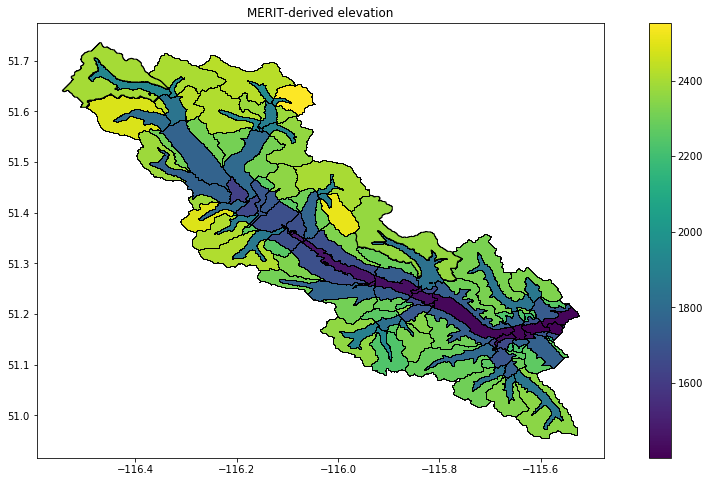

In [22]:
# Make a plot to see what we did
shp.plot(column='elevation',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('MERIT-derived elevation');

In [ ]:
# Close the netCDF file
att.close()

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [23]:
# Set the log path and file name
logPath = attribute_path
log_suffix = '_add_elevation_to_attributes.txt'

In [24]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [25]:
# Copy this script
thisFile = '2c_insert_elevation_into_attributes.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [26]:
# Get current date and time
now = datetime.now()

In [27]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Added elevation to attributes .nc file.']
    for txt in lines:
        file.write(txt) 